<a href="https://colab.research.google.com/github/laysearaujo/Classificador-de-Uso-de-mascara-por-CNN/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando dataset

Para poupar tempo o dataset é instalado usando a própria biblioteca do kaggle que baixar o arquivo do dataset em formato de zip e em seguida abrimos esse arquivo para utilizamos no código

In [ ]:
!pip install -Uqq kaggle

In [ ]:
from fastai.imports import *

In [ ]:
creds = '{"username":"laysearaujo","key":""}'

In [ ]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [ ]:
!kaggle datasets download andrewmvd/face-mask-detection

 95% 378M/398M [00:02<00:00, 176MB/s]
100% 398M/398M [00:02<00:00, 164MB/s]


In [ ]:
!unzip face-mask-detection.zip

Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  inflating: annotations/maksssk

# Importando bibliotecas

Aqui juntamos todas as bibliotecas que estamos importando para o projeto

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from google.colab.patches import cv2_imshow

In [ ]:
from keras import Sequential
# from keras.applications.vgg19 import VGG19
# from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import glob
from PIL import Image

import cv2
import seaborn as sns 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report

# Dataset

Funções necessárias para leitura do dataset que consiste na imagem e um arquivo xml que já contém as coordenadas dos rostos e se está usando ou não a máscara alé de informar se o caso esteja usando o uso está correto ou incorreto

In [ ]:
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   


def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

#Exemplo

Aqui mostramos um exemplo de como os rostos são dados pelo dataset e como conseguimos manipular esse dado

In [ ]:
input_data_path = 'images'
annotations_path = "annotations"
images = [*os.listdir("images")]
output_data_path =  '.'

In [ ]:
img = cv2.imread("images/maksssksksss0.png")
orig_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Convertendo a imagem em preto e branco
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

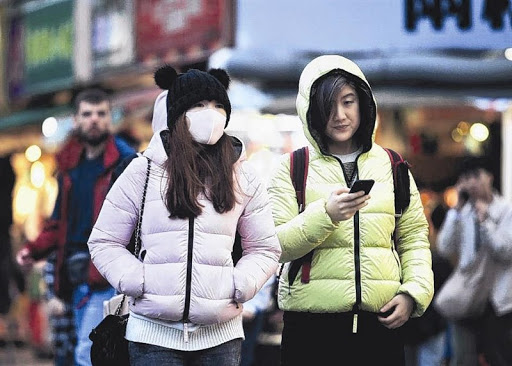

In [ ]:
# Mostrando imagem original como nos é dada, sem manipulação
cv2_imshow(img)

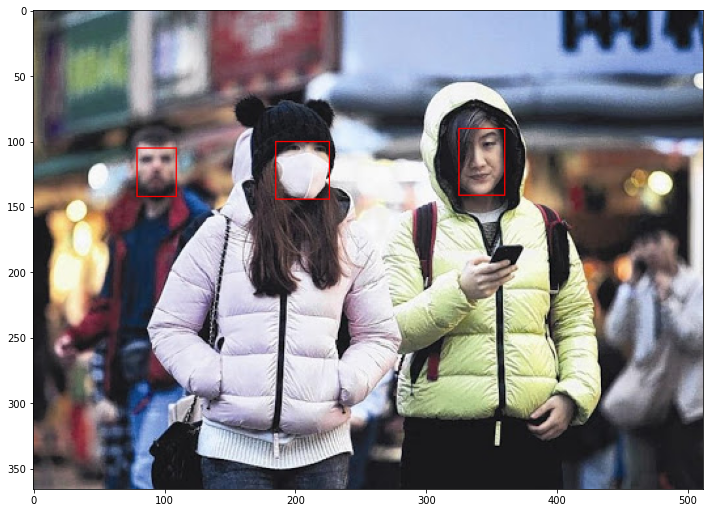

In [ ]:
# detectando os rostos na imagem
test = parse_annotation("/content/annotations/maksssksksss0.xml")
# print(test)

for face in test:
  cv2.rectangle(orig_img, (face['xmin'], face['ymin']), (face['xmax'], face['ymax']), (255, 0, 0), 1)

plt.figure(figsize=(12, 12))
plt.imshow(orig_img)

# Manipulando Dataset

No exemplo fizemos para apenas uma imagem a carater de demostração, agora faremos para todos os dados do dataset e colacaremos em uma tabela para melhor manipulação

In [ ]:
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

full_dataset = sum(dataset, [])

df = pd.DataFrame(full_dataset)
df.shape

(4072, 9)

Vizualização de como ficou a tabela após a extração dos dados dos arquivos xml

In [ ]:
df.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss463,365,400,3,with_mask,136,101,258,226
1,maksssksksss610,400,210,3,with_mask,117,66,141,93
2,maksssksksss610,400,210,3,with_mask,122,124,137,139
3,maksssksksss610,400,210,3,with_mask,192,22,227,63
4,maksssksksss341,301,400,3,with_mask,67,197,160,318


Teste para saber se nosso path não está corrompido

In [ ]:
final_test_image = 'maksssksksss1'
df_final_test = df.loc[df["file"] == final_test_image]
images.remove(f'{final_test_image}.png')
df = df.loc[df["file"] != final_test_image]

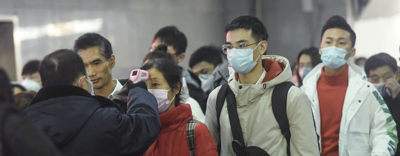

In [ ]:
img = cv2.imread("images/" + f'{final_test_image}.png')
cv2_imshow(img)

Fazendo contagem dos nossos rótulos já que uma única pode conter várias pessoas e cada pessoa contém um rótulo, lembrando que nosso treinamento será baseado nas imagens já cortadas nas coordenadas dos rostos, logo não faremos o reconhecemento de faces, apenas identifamos que uma face já definida contém ou não uma máscara e se seu uso está correto ou não. Em segida plotamos um gráfico para termos o comparado desses dados de maneira visual.

In [ ]:
df["name"].value_counts()

with_mask                3224
without_mask              716
mask_weared_incorrect     123
Name: name, dtype: int64

Text(0, 0.5, 'name')

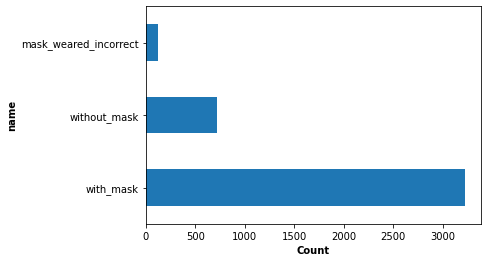

In [ ]:
df["name"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('name', fontsize = 10, fontweight = 'bold')

#Separação do Dataset

Nosso dataset é baseado previamente em imagens mas como dito anteriormente usaremos as imagens já cortadas em faces para fazer nosso treinamento e a partir dessas novas imagens faremos nossa separação em: treinamento, validação e testes. Em cada um desses bancos teremos a separação interna entre as labels que são: pessoas com máscaras, pessoas sem máscaras e pessoas usando a máscara incorretamente. 

In [ ]:
# Criando pastas que usaremos para fazer a separação de treino, validação e testes
labels = df['name'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        if not os.path.exists(path):
            os.makedirs(path)

In [ ]:
# Função de cortar imagens
def crop_img(image_path, x_min, y_min, x_max, y_max):
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [ ]:
# Função para extrair a face a partir do arquivo xml
def extract_faces(image_name, image_info):
    faces = []
    df_one_img = image_info[image_info['file'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'name']]
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [ ]:
cropped_faces = [extract_faces(img, df) for img in images]

In [ ]:
# Para conseguir fazer o for em um array a seguir
flat_cropped_faces = sum(cropped_faces, [])

In [ ]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

Aqui podemos observar que fizemos as manipulações corretamente já que os valores batem com os valores apresentados anteriormente e assim podemos seguir com a separação

In [ ]:
print('with_mask ' + str(len(with_mask)))
print('without_mask ' + str(len(without_mask)))
print('mask_weared_incorrect ' + str(len(mask_weared_incorrect)))
print('total ' + str(len(with_mask) + len(without_mask) + len(mask_weared_incorrect)))

with_mask 3224
without_mask 716
mask_weared_incorrect 123
total 4063


Aqui fizemos a separação inicial de 70-20 onde 70% do nosso dataset é usado para treino e 20% para testes. Vale ressaltar que essa separação é feita para cada label e não no dataset inteiro. E os 10% restantes usados para a validação

In [ ]:
train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

Salvando cada imagem (já da face) na pasta correspondente

In [ ]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)  


In [ ]:
for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
        
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')

In [ ]:
batch_size = 8 # O tamanho do lote é o número de unidades fabricadas em uma execução de produção.
epochs = 50 # quantidade de vezes que o dataset de treino será visto completamente

# image augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory='train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3249 images belonging to 3 classes.
Found 571 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


#Modelo CNN

Utilizamos a rede neural convolucional (CNN) que tem uma arquitetura especial que é particularmente bem adequada para classificar imagens. O uso dessa arquitetura torna as redes convolucionais rápidas de treinar, o que é vantajoso para trabalhar com redes profundas.

Um modelo que utiliza CNN consiste, em suas versões mais simples, em três camadas principais: Camada Convolucional, Camada de Pooling e Camada Totalmente Conectada.

1. Camada Convolucional: Esta camada extrai recursos de alto 
nível dos dados de entrada e os repassa para a próxima camada na forma de mapas de recursos.

2. Camada de Pooling: É usada para reduzir as dimensões dos dados aplicando camadas de agrupamento (Pooling). Essa camada recebe cada saída do mapa de recursos da camada convolucional e prepara um mapa de características condensadas.

3. Camada Totalmente Conectada: Finalmente, a tarefa de classificação é feita pela camada totalmente conectada. As pontuações de probabilidade são calculadas para cada rótulo de classe por uma função de ativação popularmente chamada de função softmax.

No modelo CNN criado, há uma camada CNN de entrada, seguida por duas camadas CNN ocultas, uma camada densa oculta e, finalmente, uma camada densa de saída. Em termos mais simples, as funções de ativação são responsáveis ​​por tomar decisões de passar o que foi identificado adiante ou não. Em uma rede neural profunda como a CNN, existem muitos neurônios e, com base nas funções de ativação, os neurônios disparam e a rede avança, nesse caso utilizamos a função de ativação ReLU que é a função de ativação mais amplamente utilizada ao projetar redes neurais atualmente. Primeiramente, a função ReLU é não linear, o que significa que podemos facilmente copiar os erros para trás e ter várias camadas de neurônios ativados pela função ReLU.

Na ultima camada utilizamos a função de ativação softmax que é usada em redes neurais de classificação. Ela força a saída de uma rede neural a representar a probabilidade dos dados serem de uma das classes definidas. Sem ela as saídas dos neurônios são simplesmente valores numéricos onde o maior indica a classe vencedora.

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

Setando os parametros

In [ ]:
data_size = len(train_generator)

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

Utilizamos o early stopping como uma forma de regularização usada para evitar o 

---

overfitting

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [ ]:
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

Durante o processo de treino, o modelo percorrerá o dataset e aprenderá os padrões. Ele treinará quantas vezes for definido ou até chegar no early stopping. Nesse caso deefinimos 50 épocas e um early stopping de 8, ou seja, se em 8 épocas seguidas não houver aprendizado o modelo para. Durante o processo, o modelo da CNN vai aprender e também cometer erros. Para cada erro (previsões erradas) que o modelo comete, há uma penalidade (ou um custo) e isso é representado no valor da perda (loss) para cada época. Resumindo, o modelo deve gerar o mínimo de perda e a maior precisão possível no final da última época.

In [ ]:
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


50/50 [==============================] - 10s 26ms/step - loss: 0.5910 - accuracy: 0.7800 - recall: 0.7500 - precision: 0.7853 - auc: 0.9081 - val_loss: 0.5532 - val_accuracy: 0.7222 - val_recall: 0.6667 - val_precision: 0.7742 - val_auc: 0.9202 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 1s 17ms/step - loss: 0.3974 - accuracy: 0.8600 - recall: 0.8225 - precision: 0.8750 - auc: 0.9571 - val_loss: 0.2123 - val_accuracy: 0.9028 - val_recall: 0.9028 - val_precision: 0.9028 - val_auc: 0.9878 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 1s 17ms/step - loss: 0.3524 - accuracy: 0.9025 - recall: 0.8975 - precision: 0.9112 - auc: 0.9677 - val_loss: 0.2411 - val_accuracy: 0.8889 - val_recall: 0.8889 - val_precision: 0.9014 - val_auc: 0.9847 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 1s 17ms/step - loss: 0.3571 - accuracy: 0.8750 - recall: 0.8600 - precision: 0.9173 - auc: 0.9636 - val_loss: 0.2947 - val_accuracy: 0.9028 - val_recall: 

#Resultados

Como conseguimos observar acima nosso modelo rodou 19 épocas e após isso a taxa de aprendiado diminui logo paramos o modelo ai a partir do early stopping

In [ ]:
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)
print(f'{model_loss} || {model_acc*100} || {recall*100} || {precision*100} || {auc*100}')

31/31 [==============================] - 0s 11ms/step - loss: 0.1748 - accuracy: 0.9630 - recall: 0.9547 - precision: 0.9627 - auc: 0.9892
0.17477774620056152 || 96.29629850387573 || 95.47325372695923 || 96.26556038856506 || 98.92081618309021


Nossa acurácia foi de: 0.9259

Lembrando que a acurácia é a proximidade de um resultado com o seu valor de referência real. Dessa forma, quanto maior o nível de acuracidade, mais próximo da referência ou valor real é o resultado encontrado.

In [ ]:
predictions = model.predict(test_generator)
predictions

31/31 [==============================] - 0s 7ms/step


array([[4.53167921e-03, 9.95379090e-01, 8.92309836e-05],
       [5.77667177e-01, 4.03872043e-01, 1.84607282e-02],
       [4.26554196e-02, 1.16079457e-01, 8.41265142e-01],
       [2.28869751e-01, 5.07986605e-01, 2.63143599e-01],
       [6.97065219e-02, 5.65639377e-01, 3.64654124e-01],
       [2.75073275e-02, 9.47543442e-01, 2.49491408e-02],
       [1.92335080e-02, 9.76061702e-01, 4.70488146e-03],
       [5.55621367e-03, 9.91285622e-01, 3.15815140e-03],
       [5.01088332e-04, 9.99486089e-01, 1.27272197e-05],
       [1.79060595e-03, 9.98199463e-01, 9.90170065e-06],
       [2.54160678e-03, 9.97329593e-01, 1.28771164e-04],
       [6.39041013e-04, 9.99340594e-01, 2.03270720e-05],
       [3.82925820e-04, 9.99613702e-01, 3.41902523e-06],
       [2.71310415e-02, 9.30313826e-01, 4.25551385e-02],
       [9.47834644e-03, 9.88842607e-01, 1.67904480e-03],
       [1.95811060e-03, 9.97986555e-01, 5.52802812e-05],
       [6.76611764e-03, 9.92314756e-01, 9.19123588e-04],
       [2.15066058e-04, 9.99774

In [ ]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

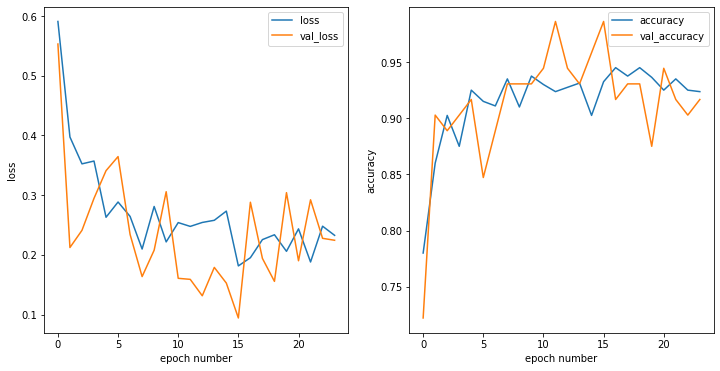

In [ ]:
plot_loss_and_accuracy(model_history.history)

31/31 [==============================] - 0s 7ms/step
with_mask || with_mask


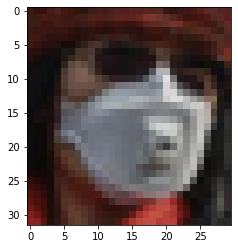

In [ ]:
paths = test_generator.filenames
y_pred = model.predict(test_generator).argmax(axis=1)
classes = test_generator.class_indices

a_img_rand = np.random.randint(0,len(paths))
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'{predicted_label} || {true_label}')

In [ ]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

31/31 [==============================] - 0s 7ms/step


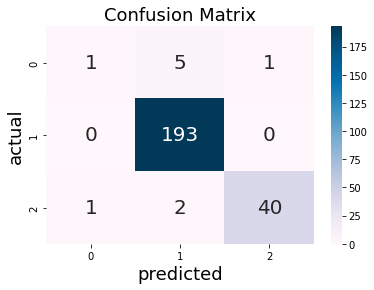

In [ ]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1)

evaluation(y_true, y_pred)

In [ ]:
display(classes)
np.bincount(y_pred)

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

array([  2, 200,  41])

#Referências

https://insightlab.ufc.br/aprenda-a-criar-e-treinar-uma-rede-neural-convolucional-cnn

https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

https://www.deeplearningbook.com.br/capitulo-23-como-funciona-o-dropout/

https://www.deeplearningbook.com.br/funcao-de-ativacao/#:~:text=ReLU&text=ReLU%20%C3%A9%20a%20fun%C3%A7%C3%A3o%20de,neur%C3%B4nios%20ativados%20pela%20fun%C3%A7%C3%A3o%20ReLU.

http://www2.decom.ufop.br/imobilis/redes-neurais-funcoes-de-ativacao/#:~:text=A%20fun%C3%A7%C3%A3o%20de%20ativa%C3%A7%C3%A3o%20softmax,maior%20indica%20a%20classe%20vencedora.

https://www.accountingtools.com/articles/batch-size#:~:text=Batch%20size%20is%20the%20number,setup%20cost%20over%20more%20units.

https://towardsdatascience.com/image-augmentation-for-deep-learning-histogram-equalization-a71387f609b2

https://en.wikipedia.org/wiki/Early_stopping

https://blog.idwall.co/o-que-e-acuracia/